<a href="https://colab.research.google.com/github/TarunVisva07/Unified-Parsing-Script/blob/main/Innovation_Practices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNIFIED PARSING SCRIPT USING MACHINE LEARNING
## INNOVATION PRACTICES
### BY
#### 19Z307 - BARATH KUMAR G
#### 19Z335 - NIRANJAN S
#### 19Z347 - SHASHAANK R
#### 19Z358 - TARUN VISVA R
#### 20Z462 - MUKESH S
#### 20Z465 - SRINIVASAN G
### GUIDED BY
#### DR. SUDHA SADHASIVAM G

## HEADERS & LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [787 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 k

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import ast
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import pickle

## MODEL

In [ ]:
class Element:
  def __init__(self, e):
    self.text = ''
    self.tag_name = ''
    self.size = {'height' : 0, 'width' : 0}
    self.location = {'x' : 0, 'y' : 0}

    try:
      self.text = e.text
    except:
      pass
    try:
      self.tag_name = e.tag_name
    except:
      pass
    try:
      self.size = e.size
    except:
      pass
    try:
      self.location = e.location
    except:
      pass

In [ ]:
class Unified_Parsing_Script:
  def __init__(self):
    self.frame = []
    self.tags = dict()
    self.area = dict()

  # Convert DataFrame to a favourable data type (lists)
  def extract_info_from_df(self, df):
    f_products = []

    for index, row in df.iterrows():
      product_info = dict()

      p_name = row['product_name']
      body_d = ast.literal_eval(row['body_dimension'])
      name_d = ast.literal_eval(row['name_dimension'])

      product_info['product_name'] = p_name
      product_info['body_dimension'] = body_d
      product_info['name_dimension'] = name_d

      f_products.append(product_info)
    
    return f_products

  # Moves the body's starting location to (0, 0) and shifts location of product name correspondingly
  def fix_starting_locations(self, products):
    for i in range(len(products)):
      if products[i]['body_dimension']['x'] != 0 or products[i]['body_dimension']['y'] != 0:
        products[i]['name_dimension']['x'] -= products[i]['body_dimension']['x']
        products[i]['name_dimension']['y'] -= products[i]['body_dimension']['y']

        products[i]['body_dimension']['x'] = 0
        products[i]['body_dimension']['y'] = 0

    return products

  def find_mean_dimensions(self, products):
    h_sum = 0
    w_sum = 0

    for p in products:
      h_sum += p['body_dimension']['height']
      w_sum += p['body_dimension']['width']
    
    return [math.ceil((h_sum/len(products))/50) * 50, math.ceil((w_sum/len(products))/50) * 50] 

  def scale_dimensions(self, products):
    h_mean, w_mean = self.find_mean_dimensions(products)

    for i in range(len(products)):
      w_scale = w_mean / products[i]['body_dimension']['width']
      products[i]['body_dimension']['width'] = w_mean
      products[i]['name_dimension']['width'] = math.ceil(products[i]['name_dimension']['width'] * w_scale)
      products[i]['name_dimension']['x'] = math.floor(products[i]['name_dimension']['x'] * w_scale)
    
    return products
  
  def initialise_frame(self, f_products):
    h_mean, w_mean = self.find_mean_dimensions(f_products)

    x = [[1 for _ in range(w_mean)] for i in range(10000)]

    return x

  def fill_frame(self, product):
    for i in range(product['name_dimension']['height']):
      for j in range(product['name_dimension']['width']):
        try:
          self.frame[i + product['name_dimension']['y']][j + product['name_dimension']['x']] += 1
        except:
          pass

  def heatmap2d(self, arr: np.ndarray):
    f = plt.figure()
    f.set_figwidth(5)
    f.set_figheight(8)

    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

  def visualize_frame(self, length = -1):
    if length == -1:
      length = len(self.frame)
    self.heatmap2d(np.matrix(self.frame[:length]))

  def convert_prob(self, count):
    for i in range(len(self.frame)):
      for j in range(len(self.frame[0])):
        self.frame[i][j] /= count

  def train_position_based_model(self, df):
    products = self.extract_info_from_df(df)
    products = self.fix_starting_locations(products)
    products = self.scale_dimensions(products)

    self.frame = self.initialise_frame(products)

    for p in products:
      self.fill_frame(p)
    
    self.convert_prob(len(products))

    print("<-- Training of the position based model has completed -->")

  def fetch_all_elements(self, link):
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    driver = webdriver.Chrome('chromedriver', options = options)
    driver.get(link)

    elements = driver.find_elements(By.XPATH, value = './/*')
    body = driver.find_element(By.TAG_NAME, value = 'html')
    return elements, body

  def find_dimensions_location(self, element):
    try:
      data = element.location
      data.update(element.size)
      return data
    except:
      return -1

  def scale_filter_elements(self, elements, body):
    filtered_elements = []
    b_dimension = self.find_dimensions_location(body)

    for e in elements:
      e_d = self.find_dimensions_location(e)
      if e_d == -1 or e.text == '' or e_d['width'] == 0 or e_d['height'] == 0:
        continue

      e_d['x'] -= b_dimension['x']
      e_d['y'] -= b_dimension['y']
      filtered_elements.append([e, e_d])

    b_dimension['x'] = 0
    b_dimension['y'] = 0
    h_mean = len(self.frame)
    w_mean = len(self.frame[0])

    for i in range(len(filtered_elements)):
      w_scale = w_mean / b_dimension['width']
      filtered_elements[i][1]['width'] = math.ceil(filtered_elements[i][1]['width'] * w_scale)
      filtered_elements[i][1]['x'] = math.floor(filtered_elements[i][1]['x'] * w_scale)

    return filtered_elements

  def element_representation_probability(self, element):
    try:
      e = element[0]
      e_d = element[1]
      grid_sum = 0
      grid_count = 0
      for i in range(e_d['height']):
        for j in range(e_d['width']):
          try:
            grid_sum += self.frame[i + e_d['y']][j + e_d['x']]
            grid_count += 1
          except:
            pass

      mean_probability = grid_sum / grid_count
      return mean_probability
    
    except:
      return 0

  def get_top_n(self, probs, n = 5):
    top_predictions = []
    p_name_dict = list(sorted(probs.items(), key = lambda kv : kv[1], reverse = True))
    for i in range(min(n, len(p_name_dict))):
      top_predictions.append((p_name_dict[i][0], p_name_dict[i][1]))
    return top_predictions

  def predict_position_based_model(self, product_elements, product_body):
    fs_elements = self.scale_filter_elements(product_elements, product_body)

    position_text_probability = dict()
    for element in fs_elements:
      position_text_probability[element[0].text] = max(self.element_representation_probability(element),
                                                       position_text_probability.get(element[0].text, -1))
    
    return position_text_probability

  def tag_count(self, df):
    tags = dict()
    for i in df.index:
      try:
        elements, _ = self.fetch_all_elements(df['product_link'][i])
        for e in elements:
          try:
            if e.text.strip() == df['product_name'][i].strip():
              tags[e.tag_name] = tags.get(e.tag_name, 0) + 1
          except:
            continue

      except:
        continue

    return tags

  def train_tag_based_model(self, df):
    self.tags = self.tag_count(df)

    print("<-- Training of the tag based model has completed -->")

  def test_link_extraction(self, elements):
    sum = 0
    p_text = dict()
    for x in self.tags:
      sum += self.tags[x]

    for e in elements:
      try:
        p_tag = self.tags.get(e.tag_name, 1) / sum
        p_text[e.text] = max(p_text.get(e.text, 0), p_tag)
      except:
        continue

    return p_text

  def predict_tag_based_model(self, elements):
    tag_text_probability = self.test_link_extraction(elements)
    
    return tag_text_probability

  def get_areas(self, df):
    areas = []
    for i in range(len(df)):
      name_dims = ast.literal_eval(df.iloc[i]['name_dimension'])
      body_dims = ast.literal_eval(df.iloc[i]['body_dimension'])
      name_area = name_dims['height']*name_dims['width']
      body_area = body_dims['height']*body_dims['width']
      areas.append(name_area)
    return areas

  def calculate_zscore(self, area):
    mean = self.area['mean']
    std = self.area['std']
    zscore = (area - mean) / std
    return zscore

  def is_outlier(self, area):
    mean = self.area['mean']
    std = self.area['std']
    zscore = self.calculate_zscore(area)
    if(abs(zscore)>3):
      return True
    return False

  def train_dimension_based_model(self, df):
    areas = self.get_areas(df)
    self.area['mean'] = np.mean(areas)
    self.area['std'] = np.std(areas)
    print("<-- Training of the dimension based model has completed -->")

  def get_probs(self, all_elements):
    probs = dict()
    for ele in all_elements:
      try:
        a = ele.size['height']*ele.size['width']
        if(ele.text != "" and not self.is_outlier(a)):
          zscore = self.calculate_zscore(a)
          std = self.area['std']
          prob = 1/(zscore*std)
          probs[ele.text] = max(prob, probs.get(ele.text, -1))
      except:
        pass
    return probs

  def predict_dimension_based_model(self, elements):
    dimension_text_probability = self.get_probs(elements)
    
    return dimension_text_probability

  def filterer(self, element):
    try:
      size = element.size
      area = size['height']*size['width']
      return not self.is_outlier(area)
    except Exception as e:
      return False

  def fit(self, pdf, tdf = -1, ddf = -1):
    if tdf == -1:
      tdf = pdf
    if ddf == -1:
      ddf = tdf

    self.train_dimension_based_model(ddf)
    self.train_tag_based_model(tdf)
    self.train_position_based_model(pdf)

    print("<-- Model fully trained -->")

  def getList(self, d):
    result = []
    for k in d.keys():
      result.append(k)
    return result

  def convert_elements(self, elements):
    filtered = []
    for e in elements:
      try:
        filtered.append(Element(e))
      except:
        pass
    return filtered

  def predict(self, query, n = 5, default_val = 0.001, for_acc = False):
    elements, body = self.fetch_all_elements(query)
    filtered = list(filter(self.filterer, elements))
    filtered = self.convert_elements(filtered)
    tp = self.predict_tag_based_model(filtered)
    pp = self.predict_position_based_model(filtered, body)

    net_probs = dict()
    texts = set([*tp] + [*pp])
    for t in texts:
      if len(t) > 0:
        net_probs[t] = tp.get(t, default_val) * pp.get(t, default_val)
    if for_acc:
      dp = self.predict_dimension_based_model(filtered)
      return self.get_top_n(net_probs, n = n), self.get_top_n(tp, n = n), self.get_top_n(pp, n = n), dp
    else:
      return self.get_top_n(net_probs, n = n)
  
  def accuracy(self, df, n = 5):
    result = [0 for _ in range(n)]
    result_pp = [0 for _ in range(n)]
    result_tp = [0 for _ in range(n)]
    result_dp = 0
    count = 0
    for _, row in df.iterrows():
      count += 1
      try:
        predictions, predictions1, predictions2, predictions3 = self.predict(row['product_link'], n = n, for_acc = True)
        for i in range(n):
          try:
            if row['product_name'].strip() == predictions[i][0].strip():
              result[i] += 1
          except:
            pass
          try:
            if row['product_name'].strip() == predictions1[i][0].strip():
              result_tp[i] += 1
          except:
            pass
          try:
            if row['product_name'].strip() == predictions2[i][0].strip():
              result_pp[i] += 1
          except:
            pass
        try:
          for x in predictions3:
            if x.strip() == row['product_name'].strip():
              result_dp += 1
              break
        except:
          pass
      except:
        pass

    result_dp  = result_dp * 100 / count
    for i in range(n):
      result[i] = result[i] * 100 / count
      result_tp[i] = result_tp[i] * 100 / count
      result_pp[i] = result_pp[i] * 100 / count

    results = {
        'complete model' : result,
        'tag based model' : result_tp,
        'position based model' : result_pp,
        'dimension based model' : result_dp
    }
    return results



## TRAINING FOR SAMPLE DATASET - POSITION BASED

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/UPS_Dataset/Sample_dataset.csv')
df

,Unnamed: 0,product_link,product_name,name_dimension,body_dimension
0,0,https://www.gonoise.com/products/noise-colorfi...,ColorFit Ultra 2,"{'x': 0, 'y': 2075, 'height': 62, 'width': 785}","{'x': 0, 'y': 0, 'height': 9948, 'width': 785}"
1,1,https://in.puma.com/in/en/pd/star-vital-mens-r...,Star Vital Men's Running Shoes,"{'x': 124, 'y': 1005, 'height': 40, 'width': 537}","{'x': 0, 'y': 0, 'height': 5076, 'width': 785}"
2,2,https://rog.asus.com/in/laptops/rog-strix/2021...,ROG Strix G17 G713,"{'x': 40, 'y': 70, 'height': 24, 'width': 360}","{'x': 0, 'y': 0, 'height': 22044, 'width': 800}"
3,3,https://www.1mg.com/otc/tata-1mg-immunity-well...,Tata 1mg Immunity & Wellness Supplement Tablet,"{'x': 283, 'y': 339, 'height': 94, 'width': 218}","{'x': 0, 'y': 0, 'height': 7820, 'width': 785}"
4,4,https://himalayawellness.in/products/purifying...,Purifying Neem Face Wash,"{'x': 418, 'y': 423, 'height': 34, 'width': 358}","{'x': 0, 'y': 0, 'height': 5322, 'width': 785}"
5,5,https://pharmeasy.in/health-care/products/hi-l...,Hi Life Multi Layered Kn95 Mask- Single Pack,"{'x': 305, 'y': 165, 'height': 30, 'width': 344}","{'x': 0, 'y': 0, 'height': 4221, 'width': 785}"
6,6,https://www.woodlandworldwide.com/collections/...,THRILL SEEKERS CAMEL,"{'x': 30, 'y': 783, 'height': 20, 'width': 735}","{'x': 0, 'y': 0, 'height': 2255, 'width': 795}"
7,7,https://www.bajajfinservmarkets.in/emi-store/o...,Oppo F21 Pro 5G 128 GB Storage Rainbow Spectru...,"{'x': 20, 'y': 662, 'height': 19, 'width': 467}","{'x': 0, 'y': 0, 'height': 5226, 'width': 795}"
8,8,https://www.lg.com/in/washing-machines/lg-t65s...,LG 6.5 kg 5 Star Inverter Fully Automatic Top ...,"{'x': 452, 'y': 278, 'height': 84, 'width': 303}","{'x': 0, 'y': 0, 'height': 9488, 'width': 785}"
9,9,https://www.bata.in/bata-sneaker-for-men-500_0...,BATA NAVY SNEAKER FOR MEN,"{'x': 432, 'y': 297, 'height': 60, 'width': 338}","{'x': 0, 'y': 0, 'height': 2668, 'width': 785}"


In [ ]:
ups = Unified_Parsing_Script()

In [ ]:
ups.train_position_based_model(df)

<-- Training of the position based model has completed -->


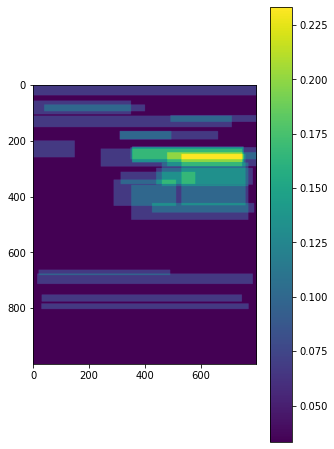

In [ ]:
ups.visualize_frame(1000)

## TRAINING FOR SAMPLE DATASET - TAG BASED

In [ ]:
ups.train_tag_based_model(df)

In [ ]:
ups.tags

{'a': 8,
 'dd': 1,
 'div': 11,
 'h1': 27,
 'h5': 1,
 'li': 6,
 'p': 1,
 'span': 7,
 'strong': 2}

## TRAINING FOR SAMPLE DATASET - DIMENSION BASED

In [ ]:
def validate(link, product_name):
  all_elements = ups.fetch_all_elements(link)
  total = len(all_elements)
  filtered_elements = list(filter(ups.filterer, all_elements))
  filtered = len(filtered_elements)
  removed = total - filtered
  found = False
  for ele in filtered_elements:
    if ele.text == product_name:
      found = True
  return [total,filtered,removed,found]

In [ ]:
validation_results = []
for i in range(1):
  validation_results.append(validate(df.iloc[i]['product_link'], df.iloc[i]['product_name']))

validation_df = pd.DataFrame(validation_results, columns=['Total elements', 'Elements Filtered', 'Elements Removed', 'Product name found'])

In [ ]:
validation_df

,Unnamed: 0,Total_elements,Elements_filtered,Elements_removed,Product_name_found
0,0,4677,4409,268,True
1,1,1699,1342,357,True
2,2,2652,2552,100,True
3,3,2359,2226,133,True
4,4,962,861,101,True
5,5,914,862,52,True
6,6,6467,6133,334,True
7,7,3393,3146,247,True
8,8,2281,2054,227,True
9,9,1911,1723,188,True


In [ ]:
ups.train_dimension_based_model(df)

<-- Training of the dimension based model has completed -->


In [ ]:
ups.area

{'mean': 20418.4, 'std': 12167.837478642894}

In [ ]:
ups.predict_dimension_based_model('https://www.realme.com/in/realme-narzo-10')

[('Free shipping', 0.0017193947730398942),
 ('Secure payment', 0.0017193947730398942),
 ('Cash On Delivery', 0.0017193947730398942),
 ('© 2018-2022 realme. All Rights Reserved.', 0.0008463100880162502),
 ('realmeow\n|\nBrand\n|\nSupport\n|\nCommunity\n|\nApp\n|\nrealme Stores\n|\nBulk Order\n|\nUI 3.0',
  0.0006975446428571435)]

## TRAINING FOR SAMPLE DATASET - COMPLETE MODEL

In [ ]:
ups.fit(df)

<-- Training of the dimension based model has completed -->
<-- Training of the tag based model has completed -->
<-- Training of the position based model has completed -->
<-- Model fully trained -->


### STORING TRAINED MODEL

In [ ]:
with open('/content/drive/MyDrive/ML/UPS_Dataset/trained_model' , 'wb') as f:
    pickle.dump(ups, f)

### TESTING SAMPLES

In [ ]:
ups.predict('https://www.realme.com/in/realme-narzo-10', 5)

[('realme narzo-10', 0.028735632183908042),
 ('Download App to Grab realme Coins !', 0.012643678160922163),
 ('Open APP', 0.012643678160919219),
 ('Support', 0.012327586206896415),
 ('Download App to Grab realme Coins !\nOpen APP', 0.011637931034479257)]

In [ ]:
ups.predict('https://www.nike.com/in/t/air-jordan-1-zoom-cmft-shoes-mDxHSk/CT0978-501')

[('Air Jordan 1 Zoom Cmft', 0.0216190453083846),
 ('₹12,495\nincl. of taxes and duties', 0.01797182113230398),
 ('₹12,495', 0.011827956989247304),
 ('We think you are in United States. Update your location?\nIndia\nUnited States',
  0.009733422939064108),
 ('incl. of taxes and duties', 0.007967443249702118)]

In [ ]:
ups.predict('https://www.flipkart.com/puma-hustle-v2-running-shoes-men/p/itm7827dd756c4f3?pid=SHOG4JEY3UZHBYRB&lid=LSTSHOG4JEY3UZHBYRBWBEBS2&marketplace=FLIPKART&store=osp%2Fcil&srno=b_1_3&otracker=hp_omu_Today%2527s%2BFashion%2BDeals_3_7.dealCard.OMU_7R4CYLDO1WJ5_5&otracker1=hp_omu_PINNED_neo%2Fmerchandising_Today%2527s%2BFashion%2BDeals_NA_dealCard_cc_3_NA_view-all_5&fm=neo%2Fmerchandising&iid=ff23f704-9a3e-4df5-9721-82f312c067a6.SHOG4JEY3UZHBYRB.SEARCH&ppt=hp&ppn=homepage&ssid=9hb80reqzk0000001653209671134', n = 10)

[('₹3,999', 0.03440860215053703),
 ('61% off', 0.03440860215053687),
 ('₹1,529₹3,99961% off', 0.03235779903204046),
 ('₹1,529', 0.031324337494630136),
 ('4.235,029 ratings and 3,838 reviews', 0.029957330602497032),
 ('4.2', 0.025089905419498532),
 ('Available offers', 0.022724393333982122),
 ('PUMA \nHustle V2 Running Shoes For Men  (Black)', 0.021410559399672353),
 ('35,029 ratings and 3,838 reviews', 0.019762452271960437),
 ('Footwear', 0.017741935483870836)]

## TESTING THE TRAINED MODEL

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/ML/UPS_Dataset/test_ups.csv', index_col = False)
test_df

,Unnamed: 0,Unnamed: 0.1,product_link,product_name,name_dimension,body_dimension
0,0,0,https://www.amazon.in/-/hi/American-Tourister-...,American Tourister Casual Backpack,"{'x': 480, 'y': 201, 'height': 64, 'width': 250}","{'x': 0, 'y': 0, 'height': 10342, 'width': 785}"
1,1,1,https://www.amazon.in/-/hi/product-reviews/B09...,American Tourister Casual Backpack\n›\nग्राहको...,"{'x': 0, 'y': 107, 'height': 20, 'width': 1000}","{'x': 0, 'y': 0, 'height': 1813, 'width': 785}"
2,2,2,https://www.amazon.in/-/hi/gp/bestsellers/garden,बाग-बगीचा और आउटडोर में सर्वाधिक बिकने वाले,"{'x': 363, 'y': 323, 'height': 32, 'width': 617}","{'x': 0, 'y': 0, 'height': 12468, 'width': 785}"
3,3,3,https://www.amazon.in/-/hi/HIT-%E0%A4%8F%E0%A4...,HIT एंटी मॉस्क्विटो रैकेट - रिचार्जेबल इन्सेक्...,"{'x': 514, 'y': 191, 'height': 192, 'width': 198}","{'x': 0, 'y': 0, 'height': 12056, 'width': 785}"
4,4,4,https://www.amazon.in/-/hi/product-reviews/B07...,HIT एंटी मॉस्क्विटो रैकेट - रिचार्जेबल इन्सेक्...,"{'x': 0, 'y': 107, 'height': 20, 'width': 1000}","{'x': 0, 'y': 0, 'height': 6083, 'width': 785}"
...,...,...,...,...,...,...
890,495,495,https://www.snapdeal.com/product/bhakarwadi-gr...,Bhakarwadi - Multicolor Cotton Blend Saree Wit...,"{'x': 453, 'y': 158, 'height': 54, 'width': 393}","{'x': 0, 'y': 0, 'height': 6897, 'width': 1024}"
891,496,496,https://www.snapdeal.com/product/bhakarwadi-pu...,Bhakarwadi - Multicolor Cotton Blend Saree Wit...,"{'x': 453, 'y': 158, 'height': 54, 'width': 393}","{'x': 0, 'y': 0, 'height': 5822, 'width': 1024}"
892,497,497,https://www.snapdeal.com/product/sherine-orang...,Sherine Orange Cotton Straight Kurti -,"{'x': 453, 'y': 158, 'height': 27, 'width': 393}","{'x': 0, 'y': 0, 'height': 5069, 'width': 1024}"
893,498,498,https://www.snapdeal.com/product/night-blue-bl...,NIGHT BLUE Black Cotton Linen Blend Saree - Si...,"{'x': 453, 'y': 158, 'height': 54, 'width': 393}","{'x': 0, 'y': 0, 'height': 5842, 'width': 1024}"


### LOADING TRAINED MODEL

In [ ]:
with open('/content/drive/MyDrive/ML/UPS_Dataset/trained_model' , 'rb') as f:
    t_ups = pickle.load(f)

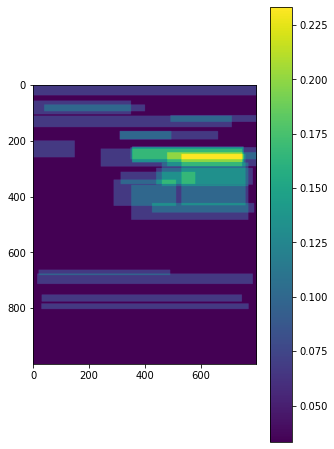

In [ ]:
t_ups.visualize_frame(1000)

In [ ]:
t_ups.predict('https://www.realme.com/in/realme-narzo-10')

[('realme narzo-10', 0.028735632183908042),
 ('Download App to Grab realme Coins !', 0.012643678160922163),
 ('Open APP', 0.012643678160919219),
 ('Support', 0.012327586206896415),
 ('Download App to Grab realme Coins !\nOpen APP', 0.011637931034479257)]

In [ ]:
results = t_ups.accuracy(df.sample(n = 1), 10)

In [ ]:
results

{'complete model': [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'dimension based model': 100.0,
 'position based model': [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'tag based model': [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

#### TESTING

In [ ]:
for i in range(10):
  r = t_ups.accuracy(test_df.sample(n = 10), 10)
  with open('/content/drive/MyDrive/ML/UPS_Dataset/Accuracies/result' + str(i) , 'wb') as f:
    pickle.dump(r, f)

In [ ]:
tag_results = [0 for _ in range(10)]
pos_results = [0 for _ in range(10)]
com_results = [0 for _ in range(10)]
dim_results = 0

In [ ]:
for i in range(10):
  with open('/content/drive/MyDrive/ML/UPS_Dataset/Accuracies/result' + str(i) , 'rb') as f:
    r = pickle.load(f)
    for j in range(10):
      tag_results[j] += (r['tag based model'][j] / 10)
      pos_results[j] += (r['position based model'][j] / 10)
      com_results[j] += (r['complete model'][j] / 10)
    dim_results += (r['dimension based model'] / 10)

for i in range(10):
  tag_results[i] = tag_results[i] * 100 / 75
  com_results[i] = com_results[i] * 100 / 75
  pos_results[i] = pos_results[i] * 100 / 75

dim_results = dim_results

In [ ]:
tag_results

[100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
com_results

[62.666666666666664,
 5.333333333333333,
 25.333333333333332,
 1.3333333333333333,
 4.0,
 1.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
dim_results

75.0

#### TESTING

In [ ]:
t_df = pd.read_csv('/content/drive/MyDrive/ML/UPS_Dataset/test2_ups.csv', index_col = False)
t_df

,Unnamed: 0,Unnamed: 0.1,product_link,product_name,final_price,product_description,name_dimension,final_price_dimension,product_description_location,body_dimension
0,0,0,https://www.croma.com/oppo-f19s-128gb-rom-6gb-...,"Oppo F19s (128GB ROM, 6GB RAM, CPH2223, Glowin...","₹19,990.00","Key Features\n16.34 cm (6.43""), FHD Plus\n6GB ...","{'x': 15, 'y': 676, 'height': 19, 'width': 755}","{'x': 15, 'y': 783, 'height': 31, 'width': 141}","{'x': 15, 'y': 971, 'height': 208, 'width': 755}","{'x': 0, 'y': 0, 'height': 3123, 'width': 785}"
1,1,1,https://www.croma.com/oppo-a96-128gb-rom-8gb-r...,"Oppo A96 (128GB ROM, 8GB RAM, Starry Black)","₹19,999.00","Key Features\n16.73cm (6.59""), FHD Plus Color ...","{'x': 15, 'y': 676, 'height': 19, 'width': 755}","{'x': 15, 'y': 783, 'height': 31, 'width': 141}","{'x': 15, 'y': 986, 'height': 208, 'width': 755}","{'x': 0, 'y': 0, 'height': 3138, 'width': 785}"
2,2,2,https://www.croma.com/oppo-f21-pro-128gb-rom-8...,"Oppo F21 Pro (128GB ROM, 8GB RAM, CPH2363, Sun...","₹22,999.00","Key Features\n6.43 cm (16.33""), AMOLED Display...","{'x': 15, 'y': 676, 'height': 19, 'width': 755}","{'x': 15, 'y': 783, 'height': 31, 'width': 145}","{'x': 15, 'y': 971, 'height': 208, 'width': 755}","{'x': 0, 'y': 0, 'height': 3123, 'width': 785}"
3,3,3,https://www.croma.com/oppo-f21-pro-128gb-rom-8...,"Oppo F21 Pro (128GB ROM, 8GB RAM, CPH2363, Cos...","₹22,999.00","Key Features\n16.33cm (6.43""), AMOLED Display\...","{'x': 15, 'y': 676, 'height': 19, 'width': 755}","{'x': 15, 'y': 783, 'height': 31, 'width': 145}","{'x': 15, 'y': 971, 'height': 208, 'width': 755}","{'x': 0, 'y': 0, 'height': 3123, 'width': 785}"
4,4,4,https://www.croma.com/vivo-v23e-5g-128gb-rom-8...,"Vivo V23e 5G (128GB ROM, 8GB RAM, V2126, Midni...","₹25,990.00","Key Features\n16.35cm (6.44”), AMOLED FHD+\n8G...","{'x': 15, 'y': 676, 'height': 19, 'width': 755}","{'x': 15, 'y': 783, 'height': 31, 'width': 146}","{'x': 15, 'y': 986, 'height': 208, 'width': 755}","{'x': 0, 'y': 0, 'height': 3138, 'width': 785}"
...,...,...,...,...,...,...,...,...,...,...
779,495,495,https://www.snapdeal.com/product/bhakarwadi-gr...,Bhakarwadi - Multicolor Cotton Blend Saree Wit...,Rs. 649,Bhakarwadi\nColor: Multicolor\nFabric: Cotton ...,"{'x': 453, 'y': 158, 'height': 54, 'width': 393}","{'x': 451, 'y': 286, 'height': 32, 'width': 80}","{'x': 55, 'y': 1809, 'height': 383, 'width': 747}","{'x': 0, 'y': 0, 'height': 6897, 'width': 1024}"
780,496,496,https://www.snapdeal.com/product/bhakarwadi-pu...,Bhakarwadi - Multicolor Cotton Blend Saree Wit...,Rs. 359,Bhakarwadi\nColor: Multicolor\nFabric: Cotton ...,"{'x': 453, 'y': 158, 'height': 54, 'width': 393}","{'x': 451, 'y': 286, 'height': 32, 'width': 78}","{'x': 55, 'y': 1809, 'height': 405, 'width': 747}","{'x': 0, 'y': 0, 'height': 5822, 'width': 1024}"
781,497,497,https://www.snapdeal.com/product/sherine-orang...,Sherine Orange Cotton Straight Kurti -,Rs. 249,Style:Straight\nFabric:Cotton\nProduct Length:...,"{'x': 453, 'y': 158, 'height': 27, 'width': 393}","{'x': 451, 'y': 259, 'height': 32, 'width': 79}","{'x': 55, 'y': 1367, 'height': 295, 'width': 747}","{'x': 0, 'y': 0, 'height': 5069, 'width': 1024}"
782,498,498,https://www.snapdeal.com/product/night-blue-bl...,NIGHT BLUE Black Cotton Linen Blend Saree - Si...,Rs. 289,Set Contents:With Blouse Piece\nFabric:Cotton ...,"{'x': 453, 'y': 158, 'height': 54, 'width': 393}","{'x': 451, 'y': 286, 'height': 32, 'width': 78}","{'x': 55, 'y': 1809, 'height': 317, 'width': 747}","{'x': 0, 'y': 0, 'height': 5842, 'width': 1024}"


In [ ]:
t_ups.accuracy(t_df.sample(n = 1), 10)

{'complete model': [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'dimension based model': 100.0,
 'position based model': [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'tag based model': [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [ ]:
for i in range(1):
  r = t_ups.accuracy(df.sample(n = 5), 10)
  with open('/content/drive/MyDrive/ML/UPS_Dataset/Accuracies/tresult' + str(i) , 'wb') as f:
    pickle.dump(r, f)

In [ ]:
tag_results = [0 for _ in range(10)]
pos_results = [0 for _ in range(10)]
com_results = [0 for _ in range(10)]
dim_results = 0

In [ ]:
for i in range(3):
  with open('/content/drive/MyDrive/ML/UPS_Dataset/Accuracies/tresult' + str(i) , 'rb') as f:
    r = pickle.load(f)
    for j in range(10):
      tag_results[j] += (r['tag based model'][j] / 10)
      pos_results[j] += (r['position based model'][j] / 10)
      com_results[j] += (r['complete model'][j] / 10)
    dim_results += (r['dimension based model'] / 10)

for i in range(10):
  tag_results[i] = tag_results[i] * 100 / 25
  com_results[i] = com_results[i] * 100 / 25
  pos_results[i] = pos_results[i] * 100 / 25

dim_results = dim_results * 100 / 30

In [ ]:
tag_results

[100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
com_results

[60.0, 8.0, 24.0, 0.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
dim_results

83.33333333333333